In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("predictive_maintenance.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [4]:
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


In [5]:
df.drop(columns=["UDI", "Product ID"], axis=1, inplace=True)

In [6]:
df["Target"].unique()

array([0, 1])

In [7]:
df["Failure Type"].unique()

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Random Failures',
       'Heat Dissipation Failure'], dtype=object)

In [8]:
df = pd.concat([df, pd.get_dummies(df["Failure Type"])], axis=1)
df.drop(columns=["Failure Type"], axis=1, inplace=True)

In [9]:
df["Type"].unique()

array(['M', 'L', 'H'], dtype=object)

In [10]:
df = pd.concat([df, pd.get_dummies(df["Type"])], axis=1)
df.drop(columns=["Type"], axis=1, inplace=True)

In [11]:
df

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Heat Dissipation Failure,No Failure,Overstrain Failure,Power Failure,Random Failures,Tool Wear Failure,H,L,M
0,298.1,308.6,1551,42.8,0,0,False,True,False,False,False,False,False,False,True
1,298.2,308.7,1408,46.3,3,0,False,True,False,False,False,False,False,True,False
2,298.1,308.5,1498,49.4,5,0,False,True,False,False,False,False,False,True,False
3,298.2,308.6,1433,39.5,7,0,False,True,False,False,False,False,False,True,False
4,298.2,308.7,1408,40.0,9,0,False,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,298.8,308.4,1604,29.5,14,0,False,True,False,False,False,False,False,False,True
9996,298.9,308.4,1632,31.8,17,0,False,True,False,False,False,False,True,False,False
9997,299.0,308.6,1645,33.4,22,0,False,True,False,False,False,False,False,False,True
9998,299.0,308.7,1408,48.5,25,0,False,True,False,False,False,False,True,False,False


In [12]:
x, y = df.drop(columns=["Target"]), df["Target"]
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
y_array = y.values
x_train, x_val, y_train, y_val = train_test_split(x_scaled,y_array,test_size=0.2,random_state=42,stratify=y_array)

In [13]:
class PredictionDataset(Dataset):
    def __init__(self,x,y):
        super().__init__()
        
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).reshape(-1,1)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [14]:
train_ds = PredictionDataset(x_train, y_train)
val_ds = PredictionDataset(x_val, y_val)

train_loader = DataLoader(train_ds,batch_size=64,shuffle=True)
val_loader = DataLoader(val_ds,batch_size=256,shuffle=False)

len(train_ds), len(val_ds)


(8000, 2000)

In [15]:
def build_model(input_dim: int) -> nn.Module:
    model = nn.Sequential(
        nn.Linear(input_dim, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 1),
        nn.Sigmoid(),
    )
    return model

In [16]:
input_dim = x_train.shape[1]
model = build_model(input_dim)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

Sequential(
  (0): Linear(in_features=14, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)

In [17]:
def train_one_epoch(model: nn.Module,
                    train_loader: DataLoader,
                    criterion,
                    optimizer) -> float:
    model.train()
    losses = []
    batches = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        batches += 1
    return sum(losses) / batches

In [18]:
def evaluate(model: nn.Module, val_loader: DataLoader) -> float:
    model.eval()
    all_true_labels = []
    all_predicted_labels = []
    
    with torch.no_grad():
        for inputs,labels in val_loader:
            outputs = model(inputs)
            predictions = (outputs >= 0.5).float()
            all_predicted_labels.extend(predictions.numpy().flatten())
            all_true_labels.extend(labels.numpy().flatten())
            
    return float(accuracy_score(all_true_labels, all_predicted_labels))

In [19]:
epochs = 10
train_losses = []
val_accuracies = []

for epoch in range(epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    val_acc = evaluate(model, val_loader)
    
    train_losses.append(train_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{epochs} | Train loss: {train_loss:.4f} | Val acc: {val_acc:.4f}")
    

Epoch 1/10 | Train loss: 0.2870 | Val acc: 0.9985
Epoch 2/10 | Train loss: 0.0242 | Val acc: 0.9990
Epoch 3/10 | Train loss: 0.0090 | Val acc: 0.9990
Epoch 4/10 | Train loss: 0.0072 | Val acc: 0.9990
Epoch 5/10 | Train loss: 0.0067 | Val acc: 0.9990
Epoch 6/10 | Train loss: 0.0065 | Val acc: 0.9990
Epoch 7/10 | Train loss: 0.0064 | Val acc: 0.9990
Epoch 8/10 | Train loss: 0.0063 | Val acc: 0.9990
Epoch 9/10 | Train loss: 0.0062 | Val acc: 0.9990
Epoch 10/10 | Train loss: 0.0062 | Val acc: 0.9990


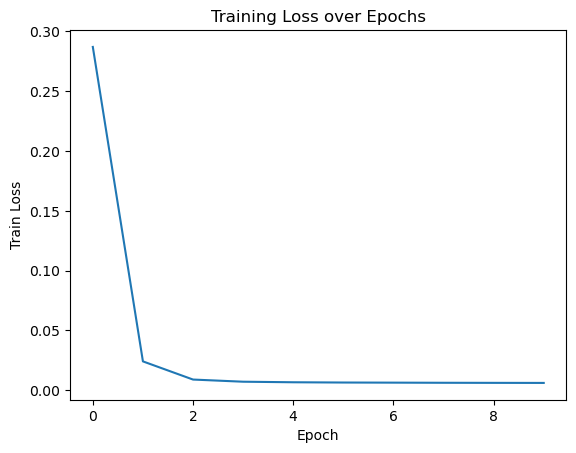

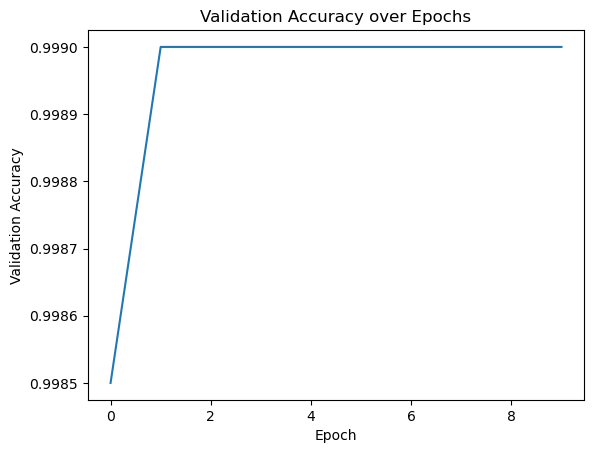

In [20]:
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss over Epochs")
plt.show()

plt.plot(val_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.show()